<a href="https://colab.research.google.com/github/shinnew9/Apziva_practice_code/blob/main/Project4-MonReader/mllm_gpt4_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from PIL import Image

image_path = Image.open("/content/drive/MyDrive/Apziva/4th_MonReader/monreader_images/images/testing/notflip/0001_000000002.jpg").convert("RGB")

### GPT-4 - separating each tasks

##### package installation

In [4]:
!pip install openai==0.28.0
# for text extraction

In [6]:
import openai
print(openai.__version__)

0.28.0


In [17]:
!pip uninstall -y openai

Found existing installation: openai 1.13.3
Uninstalling openai-1.13.3:
  Successfully uninstalled openai-1.13.3


In [3]:
!pip install --upgrade --no-cache-dir openai --quiet openai==1.13.3

# for audio

In [4]:
import openai
print(openai.__version__)

1.13.3


In [7]:
!pip uninstall -y openai httpx

Found existing installation: openai 1.13.3
Uninstalling openai-1.13.3:
  Successfully uninstalled openai-1.13.3
Found existing installation: httpx 0.28.1
Uninstalling httpx-0.28.1:
  Successfully uninstalled httpx-0.28.1


In [8]:
!pip install --no-cache-dir openai==1.13.3 httpx==0.27.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 260.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.0 which is incompatible.
google-genai 1.21.1 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.0 which is incompatible.


In [5]:
from google.colab import userdata
import openai
import base64

api_key = userdata.get('openai_api')
openai.api_key = api_key

#### Sample data

##### OCR

In [7]:
import openai
import base64
from PIL import Image
import os

def extract_text_from_image(image_path, prompt="Extract all visible text from this image. Return only raw text, no explanation."):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at path: {image_path}")

    # image encoding
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    # Calling OpenAI Vision API
    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                ]
            }
        ],
        max_tokens=1000,
    )

    # Parsing response
    result = response["choices"][0]["message"]["content"]
    return result

In [8]:
sample_korean_path = "/content/drive/MyDrive/Apziva/4th_MonReader/korocr/data/sample_image_01.png"
sample_english_path = "/content/drive/MyDrive/Apziva/4th_MonReader/IIIT5K/test/5217_1.png"

output_text = extract_text_from_image(sample_korean_path)
output_text2 = extract_text_from_image(sample_english_path)

print("OCR Korean Result:\n", output_text)
print("OCR English Result:\n", output_text2)

OCR Korean Result:
 Sample OCR Image

온 가족이 함께 즐기는
어린이
서커스 마술쇼

12.25 수요일
OCR English Result:
 THE GODS NEED A HERO  
IMMORTALS


##### Image data sample - kor, eng

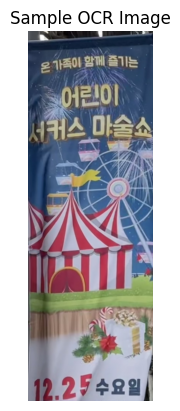

In [9]:
from PIL import Image
import io
import matplotlib.pyplot as plt


import pandas as pd
from IPython.display import display
from IPython import get_ipython


train_parquet_file = "/content/drive/MyDrive/Apziva/4th_MonReader/korocr/data/train-00000-of-00002.parquet"
df_train_parquet = pd.read_parquet(train_parquet_file)

# print(df_train_parquet.shape)
# display(df_train_parquet.head(5))

# 1st image as a sample
image_bytes = df_train_parquet.iloc[0]["image"]["bytes"]
sample_image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

# print matplotlib
plt.imshow(sample_image)
plt.axis("off")  # No axis show
plt.title("Sample OCR Image")
plt.show()

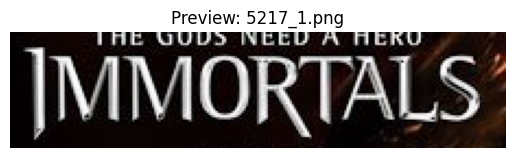

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 경로 설정
sample_english_image_path = "/content/drive/MyDrive/Apziva/4th_MonReader/IIIT5K/test/5217_1.png"

# 이미지 열기
english_sample_image = Image.open(sample_english_image_path)

# 이미지 출력
plt.imshow(english_sample_image)
plt.axis("off")  # 축 숨기기
plt.title("Preview: 5217_1.png")
plt.show()

##### TTS

In [6]:
from IPython.display import Audio

# 오디오 생성
response = openai.audio.speech.create(
    model="tts-1",  # "tts-1-hd"
    voice="nova",   # Eng: nova, shimmer / Kor: alloy, echo 등
    input=output_text
)

# 파일로
with open("output_ocr_speech.mp3", "wb") as f:
    f.write(response.content)

# ✅ Colab에서 재생
Audio("output_ocr_speech.mp3")

NameError: name 'output_text' is not defined

I tried running the full OCR-to-TTS pipeline using the OpenAI API on Colab. While the OCR part with GPT-4o worked well, I ran into repeated issues with the TTS part. Installing the right version of the `openai` package (>=1.13.3) and aligning dependencies like `httpx` kept crashing my Colab session or corrupting the environment.

### GPT-4 the whole pipeline

#### Sample data

In [11]:
from google.colab import userdata
import openai
import base64

api_key = userdata.get('openai_api')
openai.api_key = api_key

# 이미지 경로
sample_english_image_path = "/content/drive/MyDrive/Apziva/4th_MonReader/IIIT5K/test/5217_1.png"

# 이미지 base64 인코딩
with open(sample_english_image_path, "rb") as f:
    b64_image = base64.b64encode(f.read()).decode("utf-8")

# GPT-4o로 이미지 → 텍스트 → 음성 요청 (text까지 먼저 수행)
ocr_response = openai.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Please extract all visible text from this image."},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{b64_image}"}}
            ]
        }
    ]
)
eng_sample_text = ocr_response.choices[0].message.content
print("🧠 OCR Result:\n", eng_sample_text)

# 이어서 TTS 요청
tts_response = openai.audio.speech.create(
    model="tts-1",
    voice="nova",  # or "alloy" for Korean
    input=eng_sample_text
)


eng_output_path = "/content/drive/MyDrive/Apziva/4th_MonReader/gpt4_eng_sample_output.mp3"
with open(eng_output_path, "wb") as f:
    f.write(tts_response.content)


from IPython.display import Audio
Audio(eng_output_path)

🧠 OCR Result:
 THE GODS NEED A HERO  
IMMORTALS


#### the original data

In [13]:
import os
import openai
import base64
from PIL import Image
from IPython.display import Audio
from google.colab import userdata

# API key
api_key = userdata.get('openai_api')
openai.api_key = api_key

# test image
base_input_dir = "/content/drive/MyDrive/Apziva/4th_MonReader/monreader_images/images/testing"
base_output_dir = "/content/drive/MyDrive/Apziva/4th_MonReader/monreader_audio_output"

subdirs = ["flip", "notflip"]

# image extension list
image_exts = [".jpg", ".jpeg", ".png", ".bmp", ".webp"]

# OCR Function (GPT-4o)
def extract_text_from_image(image_path):
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Extract all visible text from this image. Return only the raw text."},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                ],
            }
        ],
        max_tokens=1000,
    )
    return response.choices[0].message.content.strip()

# TTS 함수
def generate_tts(text, save_path, voice="alloy"):
    """OpenAI TTS로 음성 생성"""
    response = openai.audio.speech.create(
        model="tts-1",
        voice=voice,
        input=text,
    )
    with open(save_path, "wb") as f:
        f.write(response.content)

# the whole pipline: OCR → TTS
for subdir in subdirs:
    input_dir = os.path.join(base_input_dir, subdir)
    output_dir = os.path.join(base_output_dir, subdir)
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if os.path.splitext(filename)[1].lower() in image_exts:
            image_path = os.path.join(input_dir, filename)
            audio_filename = os.path.splitext(filename)[0] + ".mp3"
            audio_path = os.path.join(output_dir, audio_filename)

            print(f"🧠 Processing: {subdir}/{filename}")

            try:
                # OCR
                text = extract_text_from_image(image_path)
                print("→ Extracted Text:", text)

                # TTS
                generate_tts(text, audio_path)
                print("✅ Audio saved:", audio_path)

            except Exception as e:
                print(f"❌ Error processing {subdir}/{filename}:", e)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

yarayı kitaba döndü 
lose, şi araştırdı 
Fı 
osyonardı. Ancak o bunun bı 
de: Müso) Homa olşe salısında tehlikeği Emma] ı nı ı 
la 
taşlarla yar 
ırancak olara 

yla 
eline 
inal ikigır 
başın 
losyo 
ostü ana bölü 
Mas 
o anı 
daki graz ı 
M 

ı 

ker bcsi yu v 

ile 
imos 
sesinehayot.sı 
sesle 
rüyada art 
is 
indanyumalarak t
ıçinde 

içinde değdi. Emma, Marlene 
cin-laniarla mal 
ger 
desse biyken 
Léon 
altındaydı I 
re işinsesli 

larda uykuya dalarlardı. 

atkes sısınıyla 又乐 ve 
aldı Tebesseterinesi 

ğının unggina 
rdımcı sedu 

Oda boştasım sarmış gibi rıun Depe 
ürm 
n, 

bu taş onun şu unutigere 
er nedensir yu 

kalır, duri 

var 
dağallak aş 

en zalıyar-coğunlika 
h hij Rendigma 

inoa 
agız o 
ek 
o 
reremher zaman benim yanımalarda, 
nasıpline 
kik 
kek 

ki 
danlsonra 

ntmişlerotunda Lucra 
mış betnisakekbertin betadefeudre 
ıma veleillirt 
ve 
k 
ıctumane 

çated 
isekomşabasag 
ağcağına gelmediği gelmek ekbela 
ar. 

masamand/ a